# Collaboration and Competition using ddpg

---

In this notebook, I use the DDPG baseline and some variation of it to train multiples agents to play tennis in a Unity ML-Agents environment. This project correspond to the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## 1. Naive Approach
### Start the Environment
First, I imports necessary packages. If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from agent import Agent

Before running the next cell, check that the path for the environment is correct. Change the `file_name` parameter to match the location of the Unity environment that you downloaded before.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

In [2]:
env = UnityEnvironment(file_name="/home/raphe/Cours/Nanodegree_DRL/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# Here we take the brain name  and set it as the default
# Environments contain brains which are responsible for deciding the actions of their associated agents
# We use 2 agents. Depending on the algorythm used to solve the environement
# the agents may collaborate or not. But from a technical point of view one could say that they are indepandant
# as they dont evolve in the same space.
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces

As I stated in README.MD, the goal of the two agents is to bounce a ball over a net using a racket as long as possible. If the agent hits the ball over the net, it receives a reward of +0.1. But, if the agent lets the ball hit the ground or hit it oustide of the table, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket.
Each agent has only two continuous actions available:
- moving toward or away the net
- jumping. 

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Take Random Actions in the Environment

In the next code cell, I use the Python API to control the agents and receive feedback from the environment.

As one can see, the comportement of each agent and his performance are really bad. 
This is due to the fact that the agent has not yet learned how to play tennis. I use a random function to define the actions values. 

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

## Training

### 1. Train one agent using DDPG  (Naive approach)
In the next code cells, you can found the body of the training code I implemented for one agent to learn how to play tennis. It uses the Python API to control the agent and receive feedback from the environment.
Here, I use the DDPG algorithm to control both racket.

In [ ]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

In [ ]:
def ddpg(env, env_info, state_size, action_size, brain_name,num_agents, agent,n_episodes=6000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations # get the current state (for each agent)
        agent.reset() # reset the noise added to the state. Makes the training more robust.
        score=np.zeros(num_agents) # initialize the score (for each agent)
        for t in range(max_t):
            actions = [agent.act(states[i],rate=0.9999) for i in range(num_agents)] # get action from each agent based on the current state
            env_info = env.step(actions)[brain_name]  # update environment informations with the actions of each agent
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            score = score+rewards  # update the score for each agent
            dones = env_info.local_done  # see if episode is finished
            agent.step(states, actions, rewards, next_states, dones,num_agents,2) # add (state,actions,rewards,next_states) to replay buffer and train the actor-critic neural network
            states = next_states # roll over the state to next time step
            if any(dones):
                break
                
        scores.append(np.max(score)) # add maximum score for to display the results later
        scores_deque.append(np.max(score)) # add maximum score to windows for convergence check
        print('\rEpisode {}\tAverage Score: {}\tScore: {}'.format(i_episode, np.mean(scores_deque), np.max(score)), end="")
        if i_episode>100 and np.mean(scores_deque)>0.5: # check if the env is solved
            print("envionment solved")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth') # save actor weights
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')# save critic weights
            return scores
        
        if i_episode%100 ==0: # save intermediary solution every 100 iter
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth') # save actor weights
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') # save critic weights
   
    return scores

In [ ]:
scores = ddpg(env, env_info, state_size, action_size, brain_name,num_agents, agent)

In [ ]:
#Episode 2546	Average Score: 0.5118000076711178	Score: 2.600000038743019envionment solved


#### Display results for naive approach training

##### Score

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 2. Train the agent using multi agents DDPG
In the next code cells, you can found the body of the training code I implemented for multi agents. It uses the Python API to control the agent and receive feedback from the environment.
Here, each agent get informations about state and action of other agent. The actor-critic network for each agent is trained using the replay buffer (each of them has a copy). Therefore, agents can substitute each other.

In [5]:
agent = [ Agent(state_size=state_size, action_size=action_size, random_seed=10) for i in range(num_agents)]

In [6]:
def multi_ddpg(env, env_info, state_size, action_size, brain_name,num_agents, agent,n_episodes=6000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations  # get the current state (for each agent)
        for i in range(num_agents):
            agent[i].reset() # reset the noise added to the state. Makes the training more robust.
        score=np.zeros(num_agents)  # initialize the score (for each agent)
        for t in range(max_t):
           # actions = agent.act(states)
            actions = [agent[i].act(states[i],rate=0.9999) for i in range(num_agents)] # get action from each agent based on the current state
            env_info = env.step(actions)[brain_name]  # update environment informations with the actions of each agent
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            score = score+rewards  # update the score for each agent
            dones = env_info.local_done  # see if episode finished
            # agent[i].step: add (states,actions,rewards,next_states) to replay buffer of each agent 
            # train the actor critic Neural Network of each agent
            # each agent share the same information
            [agent[i].step(states, actions, rewards, next_states, dones,num_agents,2) for i in range(num_agents)]
            states = next_states # roll over the state to next time step
            if any(dones):
                break
                
        scores.append(np.max(score)) # save the best agent score for display
        scores_deque.append(np.max(score)) # save the best agent score into the windows for convergence checking
        print('\rEpisode {}\tAverage Score: {}\tScore: {}'.format(i_episode, np.mean(scores_deque), np.max(score)), end="")
        if i_episode>100 and np.mean(scores_deque)>0.5: # check if env is solved
            print("envionment solved")
            [torch.save(agent[i].actor_local.state_dict(), 'multi_checkpoint_actor'+str(i)+'.pth') for i in range(num_agents)] # save actor weights for each agents
            [torch.save(agent[i].critic_local.state_dict(), 'multi_checkpoint_critic'+str(i)+'.pth') for i in range(num_agents)] # save critic weights for each agents
            return scores
        
        if i_episode%100 ==0:
            [torch.save(agent[i].actor_local.state_dict(), 'multi_checkpoint_actor'+str(i)+'.pth') for i in range(num_agents)] # save actor weights for each agents
            [torch.save(agent[i].critic_local.state_dict(), 'multi_checkpoint_critic'+str(i)+'.pth') for i in range(num_agents)] # save critic weights for each agents
   
    return scores

In [7]:
scores = multi_ddpg(env, env_info, state_size, action_size, brain_name,num_agents, agent)

Episode 1972	Average Score: 0.5029000074975193	Score: 1.0000000149011612envionment solved


In [9]:
#Episode 1972	Average Score: 0.5029000074975193	Score: 1.0000000149011612envionment solved

#### Display results for training

##### Score

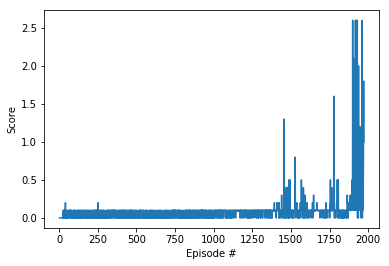

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### End of training

In [ ]:
env.close()

### 2. Test

#### Load libraries

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from agent import Agent

#### Define testing function

In [ ]:
def ddpg_Test(env,brain_name,num_agents,agent,file_name_actor,file_name_critic,n_episodes=6000, max_t=1000):
    """ Visualize agent using saved checkpoint. """
    # load saved weights
    agent.actor_local.load_state_dict(torch.load(file_name_actor))
    agent.critic_local.load_state_dict(torch.load(file_name_critic)) 
    scores = []  # list containing scores from each episode
 
    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=False)[brain_name]  # environment informations
        states = env_info.vector_observations 
        agent.reset()
        score = np.zeros(num_agents) 
        for t in range(max_t):
            actions = agent.act(states,rate=0.9999) # get action using the DDPG algorythme (for each agent)
            env_info = env.step(actions)[brain_name]  # update environment informations with the actions of each agent
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done  # see if episode finished
            states = next_states  # roll over the state to next time step
            score =score+ rewards  # update the score for each agent
            if any(dones):  # see if episode has finished
                break
        print('\rEpisode {}\tAverage Score: {}, touch: {}'.format(i_episode, np.max(score),t), end="")
        scores.append(np.max(score)) # save the best score between both agents

    return scores



In [ ]:
def double_ddpg_Test(env,brain_name,num_agents,agent,file_name_actor,file_name_critic,n_episodes=6000, max_t=1000):
    """ Visualize agent using saved checkpoint. """
    # load saved weights
    for i in range(num_agents):
        agent[i].actor_local.load_state_dict(torch.load(file_name_actor[i]))
        agent[i].critic_local.load_state_dict(torch.load(file_name_critic[i])) 
        
    scores = []                        # list containing scores from each episode
    score = 0
 
    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations 
        [agent[i].reset() for i in range(num_agents)]
        score = np.zeros(num_agents) 
        for t in range(max_t):
            actions = [agent[0].act(states[i],rate=0.9999) for i in range(num_agents)]
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            #agent.step(states, actions, rewards, next_states, dones,num_agents)
            states = next_states
            score =score+ rewards
            if any(dones):
                break
        scores.append(np.max(score)) # save the best score between both agents
    print('\rEpisode {}\tAverage Score: {}'.format(i_episode, np.max(score)), end="")
    return scores

#### Load environment

In [ ]:
env = UnityEnvironment(file_name="/home/raphe/Cours/Nanodegree_DRL/Tennis_Linux/Tennis.x86_64")

In [ ]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

In [ ]:
agent = [ Agent(state_size=state_size, action_size=action_size, random_seed=10) for i in range(num_agents)]

#### Define the weights

In [ ]:
file_name_actor=[]
file_name_critic=[]
for i in range(num_agents):
    file_name_actor.append('checkpoint_actor'+str(0)+'.pth')
    file_name_critic.append('checkpoint_critic'+str(0)+'.pth')

#### Load the weight, start testing

In [ ]:
scores=Test(env,brain_name,num_agents,agent,file_name_actor,file_name_critic ,n_episodes=20,max_t=100)

 #### Display score

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### End of testing

In [ ]:
env.close()